In [1]:
import numpy as np
import pandas as pd
import mne ,os, emd
from scipy import signal
from scipy import stats as st
import neurokit2 as nk
from tqdm import tqdm
from numba import jit
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import mutual_info_classif
import tensorflow as tf
from tensorflow import keras

In [2]:
db_patients_path  = '/home/tusharsingh/DATAs/Database_patients'
db_subjects_path  = '/home/tusharsingh/DATAs/Database_subjects'

scoring_criteria = 'HypnogramR&K_'
def file_path_aggregator(scoring_criteria, path, count, prefix):
    edf = [os.path.join(path,prefix + str(i) + '.edf') for i in range(1, count + 1)]
    txt = [os.path.join(path,scoring_criteria + prefix + str(i) + '.txt') for i in range(1, count + 1)]
    return list(zip(edf, txt))

def data_aggregator(path_list):
    EDF = []
    label = []
    for edf, txt in path_list:
        name = txt[-13:]
        edf_name = edf
        e = mne.io.read_raw(edf,verbose = False)
        # because channel name is not consistent in differnt files, 
        # hence need to search for EOG1 prefix
        # x = sorted([a for a in e.ch_names if 'EOG1' in a])[0]
        # print(dir(e))
        # print(e.get_channel_types())
        print(e.__len__)

        
        # print(e.to_data_frame().values.shape)
    #     # print(x)

    #     # edf = e.pick(x).to_data_frame()[x].values
        
    #     sos = signal.butter(8, (0.5,49.5), 'bandpass', fs = 200, output = "sos")
    #     edf = signal.sosfilt(sos, edf)
    #     with open(txt,'r') as f:
    #         lines = f.readlines()[1:]
    #         lines = [int(x[:-1]) for x in lines]
    #         txt = np.array(lines)
    #         # sleep
    #         txt[txt != 5] = 1
    #         # wake
    #         txt[txt == 5] = 0

    #     print("raw data size")
    #     print(edf.size, txt.size)

    #     txt = txt[:6*(txt.size//6)]
    #     edf = edf[:txt.size * 1000]
    #     txt = txt.reshape(-1,6)
    #     edf = edf.reshape(-1,6000)

    #     # if not (txt[:,0] == np.mean(txt, axis = 1)).all():
    #     #     print(name, "     edf_shape", edf.shape, " txt_shape", txt.shape)
    #     #     print(txt[txt[:,0] != np.mean(txt, axis = 1)])
    #     print('possible 30s epocs')
    #     print(edf_name[-6:],edf.shape, txt.shape)

    #     index = np.max(txt, axis = 1) == np.min(txt, axis = 1)
    #     txt = txt[index]
    #     edf = edf[index]
    #     txt = txt[:,0]
    #     label.append(txt)
    #     EDF.append(edf)
    #     print('epocs without ambiguity')
    #     print(edf_name[-6:],edf.shape, txt.size)
    #     print('-'*20)

    # # return list(zip(EDF, label))
    # EDF = np.vstack(EDF)
    # label = np.concatenate(label)
    # return EDF, label

In [3]:
patient_paths = file_path_aggregator(scoring_criteria, db_patients_path, 27, 'patient')
patient_data = data_aggregator(patient_paths)

subject_paths = file_path_aggregator(scoring_criteria, db_subjects_path, 20, 'subject')
subject_data = data_aggregator(subject_paths)

<bound method BaseRaw.__len__ of <RawEDF | patient1.edf, 23 x 5780000 (28900.0 s), ~26 kB, data not loaded>>
<bound method BaseRaw.__len__ of <RawEDF | patient2.edf, 15 x 6144000 (30720.0 s), ~19 kB, data not loaded>>
<bound method BaseRaw.__len__ of <RawEDF | patient3.edf, 23 x 6574000 (32870.0 s), ~26 kB, data not loaded>>
<bound method BaseRaw.__len__ of <RawEDF | patient4.edf, 23 x 6254000 (31270.0 s), ~26 kB, data not loaded>>
<bound method BaseRaw.__len__ of <RawEDF | patient5.edf, 23 x 6032000 (30160.0 s), ~26 kB, data not loaded>>
<bound method BaseRaw.__len__ of <RawEDF | patient6.edf, 23 x 6016000 (30080.0 s), ~26 kB, data not loaded>>
<bound method BaseRaw.__len__ of <RawEDF | patient7.edf, 23 x 5922000 (29610.0 s), ~26 kB, data not loaded>>
<bound method BaseRaw.__len__ of <RawEDF | patient8.edf, 23 x 6846000 (34230.0 s), ~26 kB, data not loaded>>
<bound method BaseRaw.__len__ of <RawEDF | patient9.edf, 23 x 6082000 (30410.0 s), ~26 kB, data not loaded>>
<bound method BaseR

In [4]:
# sub_eog, sub_label = subject_data
# print(sub_eog.shape, sub_label.shape)
# np.savez('/home/tusharsingh/DATAs/sub_data', a=sub_eog, b=sub_label)

data = np.load('/home/tusharsingh/DATAs/sub_data.npz')
sub_eog, sub_label = data['a'], data['b']

unique, counts = np.unique(sub_label, return_counts=True)
print (np.asarray((unique, counts)).T)

[[    0  5601]
 [    1 24800]]


In [5]:
# pat_eog, pat_label = patient_data
# print(pat_eog.shape, pat_label.shape)
# np.savez('/home/tusharsingh/DATAs/pat_data', a=pat_eog, b=pat_label)

data = np.load('/home/tusharsingh/DATAs/pat_data.npz')
pat_eog, pat_label = data['a'], data['b']

unique, counts = np.unique(pat_label, return_counts=True)
print (np.asarray((unique, counts)).T)

[[    0 11552]
 [    1 30877]]


In [6]:
def feature_maker(X):
    imf = emd.sift.ensemble_sift(X, max_imfs=5,nprocesses=5, noise_mode = 'single') # no way to set seed in this function
    # emd.plotting.plot_imfs(imf)
    imf = imf.T
    imf = np.vstack((imf, X - np.sum(imf, axis = 0)))
    IP, IF, IA = emd.spectra.frequency_transform(imf, 200, 'hilbert')
    f, hht = emd.spectra.hilberthuang(IF, IA, sample_rate=200)
    approx_entropy = nk.entropy_approximate(X)[0]
    del(IA)
    IMF_mean = np.mean(imf, axis = 1)
    IMF_mode = st.mode(imf, axis = 1)[0].flatten()
    IMF_sdiv = st.tstd(imf, axis = 1)
    IMF_kurt = st.kurtosis(imf, axis = 1)
    IMF_skew = st.skew(imf, axis = 1)
    feature = np.hstack([IMF_mean, IMF_mode, IMF_sdiv, IMF_kurt, IMF_skew])

    IF_mean = np.mean(IF,axis = 1)
    IF_median = np.median(IF, axis = 1)
    IF_variance = np.var(IF, axis = 1)
    IF_counChange = np.sum((np.diff(IF, axis = 1) != 0), axis = 1)
    IE_median = np.median(IP, axis = 1)

    feature = np.hstack([feature,IF_median, IF_mean, IF_variance, IF_counChange, IE_median])

    total_power = np.sum(hht[(0.5 <= f) & (f <= 49.5)])
    # relative power features
    theta = np.sum(hht[(3.5 <= f) & (f <= 7.5)]) / total_power
    alpha = np.sum(hht[(8.5 <= f) & (f <= 11)]) / total_power
    beta = np.sum(hht[(15.5 <= f) & (f <= 30)]) / total_power
    gamma = np.sum(hht[(30 <= f) & (f <= 49.5)]) / total_power
    delta = np.sum(hht[(0.5 <= f) & (f <= 3.5)]) / total_power
    k_complex_spindle = (np.sum(hht[(8.5 <= f) & (f <= 1.5)]) + \
        np.sum(hht[(11 <= f) & (f <= 15)])) / total_power
    alpha2theta = alpha / theta

    Relative = np.array([alpha, beta, gamma, delta, k_complex_spindle, alpha2theta,approx_entropy])
    feature = np.hstack([feature, Relative])
    return feature[:]


In [7]:
feature_maker(pat_eog[5])

array([-8.36905180e+03,  2.88370146e+04,  1.32799830e+05, -6.40862902e+05,
        3.88971444e+05,  8.11213686e+04, -4.83820325e+06, -1.68612056e+07,
       -1.41720924e+07, -2.27845522e+07, -1.29270295e+07, -9.56373309e+06,
        1.67749072e+06,  2.91116530e+06,  4.18981854e+06,  7.20859498e+06,
        4.86513802e+06,  2.79097331e+06, -7.69228004e-01,  4.82122898e+00,
        1.60649277e+00,  4.55000712e-01, -2.33810540e-01, -2.10859543e-01,
        9.80253878e-03,  3.60805050e-01,  3.78485060e-01, -3.77224984e-01,
       -7.34830951e-03, -1.62183859e-02,  2.65983227e+01,  2.65983227e+01,
        2.98108209e+01,  1.73161471e+01,  4.47444319e-15,  1.33664692e-14,
        2.82738544e+01,  2.82738544e+01,  3.30280253e+01,  1.77124486e+01,
       -1.17968551e+00, -1.17968551e+00,  6.08167346e+02,  6.08167346e+02,
        4.74656321e+02,  1.55692686e+02,  7.45441300e+01,  7.45441300e+01,
        3.99900000e+03,  3.99900000e+03,  3.99900000e+03,  3.99900000e+03,
        3.99900000e+03,  

In [8]:
# def linear_process(X):
#     final_feature = np.zeros((X.shape[0],67))
#     for i in range(X.shape[0]):
#         final_feature[i] = feature_maker(X[i])
#     return final_feature

# import concurrent.futures
# with concurrent.futures.ProcessPoolExecutor() as executor:
#     a = executor.submit(linear_process, pat_eog[:10000,:])
#     b = executor.submit(linear_process, pat_eog[10000:20000,:])
#     c = executor.submit(linear_process, pat_eog[20000:30000,:])
#     d = executor.submit(linear_process, pat_eog[30000:,:])

#     e = executor.submit(linear_process, sub_eog[:10000,:])
#     f = executor.submit(linear_process, sub_eog[10000:20000:,:])
#     g = executor.submit(linear_process, sub_eog[20000:,:])

#     pat_67 = np.vstack((a.result(), b.result(), c.result(), d.result()))
#     sub_67 = np.vstack((e.result(), f.result(), g.result()))


# storing_path = '/home/tusharsingh/DATAs/'
# np.savez('/home/tusharsingh/DATAs/pat_data_67_new', a=pat_67, b=pat_label)
# np.savez('/home/tusharsingh/DATAs/sub_data_67_new', a=sub_67, b=sub_label)

In [9]:
storing_path = '/home/tusharsingh/DATAs/'

data = np.load(storing_path + 'pat_data_67_new.npz')
pat_X, pat_y = data['a'], data['b']

data = np.load(storing_path + 'sub_data_67_new.npz')
sub_X, sub_y = data['a'], data['b']

## Testing on patents

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pat_X, pat_y, test_size=0.25, random_state=42, stratify = pat_y)

feature selection

In [11]:
# from imblearn.ensemble import RUSBoostClassifier
# def best_group(X, y): #best feature set for one trial
#     best = 0
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify = y)
#     mi_values = np.argsort(mutual_info_classif(X_train, y_train, random_state = 42))

#     for i in range(15, 66):
#         indices = mi_values[-i:]
#         train, test = X_train[ :, indices], X_test[:, indices]
#         clf = make_pipeline(StandardScaler(),RUSBoostClassifier())
#         clf.fit(train, y_train)
        
#         score = clf.score(test, y_test)
#         if score > best:
#             best_features = indices
#             best = score
#     return best_features

# import concurrent.futures
# with concurrent.futures.ProcessPoolExecutor() as executor:
#     l = [executor.submit(best_group, X_train, y_train) for i in range(5)]
#     l = [each.result().tolist() for each in l]

# l = [set(each) for each in l]
# best_features = set.intersection(*l) # as best features should be selected in all the trials

# from scipy.stats import kruskal
# final_best_fearures = []
# for each in best_features:
#     x = X_train[:,each]
#     y = y_train
#     pvalue = kruskal(x,y)[1]
#     if pvalue <= 0.05:
#         final_best_fearures.append(each)

# print(sorted(final_best_fearures), len(final_best_fearures))

In [12]:
# X_train, X_test = X_train[:, sorted(final_best_fearures)], X_test[:, sorted(final_best_fearures)]

In [19]:
model = keras.models.Sequential([
    keras.layers.BatchNormalization(input_shape = [67]),
    keras.layers.Dropout(rate = 0.5),
    keras.layers.Dense(250, activation = 'elu', kernel_initializer = 'he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate = 0.5),
    keras.layers.Dense(100, activation = 'elu', kernel_initializer = 'he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate = 0.5),
    keras.layers.Dense(50, activation = 'elu', kernel_initializer = 'he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate = 0.5),
    keras.layers.Dense(10, activation = 'elu', kernel_initializer = 'he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate = 0.5),
    keras.layers.Dense(1,  activation = 'sigmoid')
])


In [20]:
model.compile(loss = 'BinaryCrossentropy', optimizer= 'sgd', metrics= ['Accuracy'])

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience= 10, restore_best_weights= True)
history = model.fit(X_train,y_train, epochs = 200, validation_split = 0.20, use_multiprocessing = True, callbacks=[early_stopping_cb])


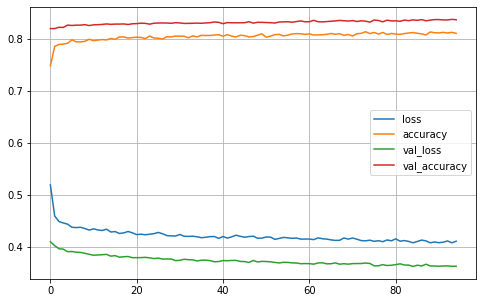

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
# plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

332/332 [==============================] - 1s 3ms/step - loss: 0.3675 - accuracy: 0.8359


[0.36750665307044983, 0.8358786106109619]

In [ ]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import cross_val_score
# base_clf = DecisionTreeClassifier(max_depth = 1)
# # base_clf = LogisticRegression()
# clf = clf = make_pipeline(StandardScaler(), RUSBoostClassifier(base_estimator = base_clf, n_estimators = 250, random_state = 42))
# score = cross_val_score(clf, X_train, y_train, cv=5)
# print(score)
# clf.fit(X_train, y_train)
# score = clf.score(X_test, y_test)
# print(score)

[0.81901021 0.82039598 0.81049654 0.80263985 0.81615336]
0.8190045248868778


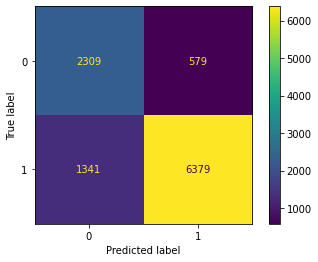

In [ ]:
# ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

testing on subjects

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(sub_X, sub_y, test_size=0.25, random_state=42, stratify = sub_y)

In [ ]:
# import concurrent.futures
# with concurrent.futures.ProcessPoolExecutor() as executor:
#     l = [executor.submit(best_group, X_train, y_train) for i in range(5)]
#     l = [each.result().tolist() for each in l]

# l = [set(each) for each in l]
# best_features = set.intersection(*l)

# from scipy.stats import kruskal
# final_best_fearures = []
# for each in best_features:
#     x = X_train[:,each]
#     y = y_train
#     pvalue = kruskal(x,y)[1]
#     if pvalue <= 0.05:
#         final_best_fearures.append(each)

# print(sorted(final_best_fearures), len(final_best_fearures))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 51, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66] 59


In [ ]:
# X_train, X_test = X_train[:, sorted(final_best_fearures)], X_test[:, sorted(final_best_fearures)]

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience= 10, restore_best_weights= True)
history = model.fit(X_train,y_train, epochs = 200, validation_split = 0.20, use_multiprocessing = True, callbacks=[early_stopping_cb])

pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
# plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

238/238 [==============================] - 1s 3ms/step - loss: 0.2757 - accuracy: 0.8903


[0.27568548917770386, 0.890277624130249]

In [ ]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import LogisticRegression
# # base_clf = DecisionTreeClassifier(max_depth = 1)
# base_clf = LogisticRegression()
# clf = clf = make_pipeline(StandardScaler(), RUSBoostClassifier(base_estimator = base_clf, n_estimators = 250, random_state = 42))
# clf.fit(X_train, y_train)
# score = clf.score(X_test, y_test)
# print(score)

0.8659386922773319


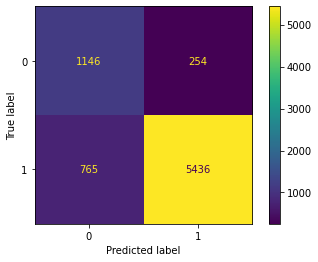

In [ ]:
# ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)